# Machine Analysis

These notebooks look to analyse the time spent by each patient at the different machines. They use the geopandas package to capture the points in the polygons representing the different machines. They then look to capture the time spent in that machine.

## Package and Function Load In

In [ ]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [ ]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 16.7 MB 372 kB/s 
     |████████████████████████████████| 6.3 MB 54.8 MB/s 
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 2.1 MB 5.2 MB/s 


## File Load In

In this section you must load in the appropriate patient journey file for analysis.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.geometry import box
from shapely import wkt
import pandas as pd
import rtree
import pygeos
import geopandas as gpd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

dftest = pd.read_csv('phase1_all.csv')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Creating the Machine Polygon or MultiPolygon

The polygon coordinates are captured using the line_with_coordinates.html file. The polygon coordinates must be entered in the order of top left, bottom left, bottom right and then top right.

In [ ]:
HFA_poly2 = Polygon([(0, 4), (0, 2.2), (2.3, 2.2), (2.3, 4)])

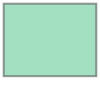

In [ ]:
HFA_poly2

In [ ]:
HFA_poly3 = Polygon([(0, 2.3), (0, 0), (8.9, 0), (8.9, 2.3)])

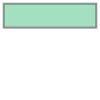

In [ ]:
HFA_poly3

## MultiPolygon Creation

In this example there are two separate sections for the machines. So multiple polygons must be created and subsequently combined to create a MultiPolygon.

In [ ]:
HFA_multipoly = MultiPolygon([HFA_poly2, HFA_poly3])

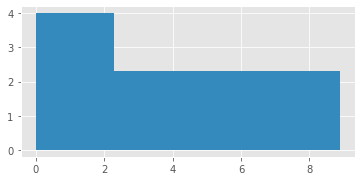

In [ ]:
 p = gpd.GeoSeries(HFA_multipoly)
 p.plot()
 plt.show()

## Data Cleaning and Formatting

In [ ]:
dftest = dftest.dropna()
dftest[['xlocation', 'ylocation']] = dftest['Location'].str.split(',', expand = True)

In [ ]:
dftest['newfrom'] = lookup(dftest['from'], format='%d/%m/%Y, %H:%M:%S')
dftest['newto'] = lookup(dftest['to'], format='%d/%m/%Y, %H:%M:%S')

In [ ]:
dfG1221 = dftest.loc[dftest['Patient'] == 'G1221']

In [ ]:
column_list = list(dftest)
column_list

['Patient',
 'Location',
 'from',
 'to',
 'xlocation',
 'ylocation',
 'newfrom',
 'newto']

## GeoPandas Dataframe Creation

This section creates a GeoPandas dataframe using the coordinates from the patient journey dataset.

The next section creates a geometry using the polygon or MultiPolygon shape that was created earlier.

In [ ]:
gdf = gpd.GeoDataFrame(
    dftest, geometry=gpd.points_from_xy(dftest.xlocation, dftest.ylocation))

In [ ]:
gdf['Location'] = gdf['Location'].astype(str)

In [ ]:
HFA_poly3_gdf = gpd.GeoDataFrame(geometry  = gpd.GeoSeries(HFA_multipoly))

In [ ]:
HFA_poly3_gdf

,geometry
0,"MULTIPOLYGON (((0.00000 4.00000, 0.00000 2.200..."


## Inner Join of the Two GeoPandas DataFrames

This section runs a spatial join of the two GeoDataframes it captures all of the points, in this example the patient journey points, that occur with in the polygon or MultiPolygon that was created earlier. This represents the time spent by the patient in the machine.

In [ ]:
HFA_join = gpd.sjoin(gdf, HFA_poly3_gdf, how = 'inner')
HFA_join

,Patient,Location,from,to,xlocation,ylocation,newfrom,newto,geometry,index_right
19,G0132,"3.522,2.048","08/11/2021, 12:37:15","08/11/2021, 12:38:06",3.522,2.048,2021-11-08 12:37:15,2021-11-08 12:38:06,POINT (3.52200 2.04800),0
20,G0132,"3.965,1.111","08/11/2021, 12:38:06","08/11/2021, 12:54:10",3.965,1.111,2021-11-08 12:38:06,2021-11-08 12:54:10,POINT (3.96500 1.11100),0
21,G0132,"4.715,1.944","08/11/2021, 12:54:10","08/11/2021, 12:54:54",4.715,1.944,2021-11-08 12:54:10,2021-11-08 12:54:54,POINT (4.71500 1.94400),0
67,G0167,"2.338,1.337","11/11/2021, 13:34:30","11/11/2021, 13:46:40",2.338,1.337,2021-11-11 13:34:30,2021-11-11 13:46:40,POINT (2.33800 1.33700),0
68,G0167,"3.402,1.498","11/11/2021, 13:46:40","11/11/2021, 13:49:02",3.402,1.498,2021-11-11 13:46:40,2021-11-11 13:49:02,POINT (3.40200 1.49800),0
...,...,...,...,...,...,...,...,...,...,...
76570,R1089,"5.672,1.728","12/11/2021, 11:51:01","12/11/2021, 11:52:03",5.672,1.728,2021-11-12 11:51:01,2021-11-12 11:52:03,POINT (5.67200 1.72800),0
76571,R1089,"5.066,0.911","12/11/2021, 11:52:03","12/11/2021, 11:52:37",5.066,0.911,2021-11-12 11:52:03,2021-11-12 11:52:37,POINT (5.06600 0.91100),0
76572,R1089,"5.785,1.615","12/11/2021, 11:52:37","12/11/2021, 11:55:38",5.785,1.615,2021-11-12 11:52:37,2021-11-12 11:55:38,POINT (5.78500 1.61500),0
76573,R1089,"4.648,1.603","12/11/2021, 11:55:38","12/11/2021, 11:55:43",4.648,1.603,2021-11-12 11:55:38,2021-11-12 11:55:43,POINT (4.64800 1.60300),0


## More data cleaning

In [ ]:
discard = ['f', 'T']
HFA_join = HFA_join[~HFA_join.Patient.str.contains(('|'.join(discard)))]
HFA_join

,Patient,Location,from,to,xlocation,ylocation,newfrom,newto,geometry,index_right
19,G0132,"3.522,2.048","08/11/2021, 12:37:15","08/11/2021, 12:38:06",3.522,2.048,2021-11-08 12:37:15,2021-11-08 12:38:06,POINT (3.52200 2.04800),0
20,G0132,"3.965,1.111","08/11/2021, 12:38:06","08/11/2021, 12:54:10",3.965,1.111,2021-11-08 12:38:06,2021-11-08 12:54:10,POINT (3.96500 1.11100),0
21,G0132,"4.715,1.944","08/11/2021, 12:54:10","08/11/2021, 12:54:54",4.715,1.944,2021-11-08 12:54:10,2021-11-08 12:54:54,POINT (4.71500 1.94400),0
67,G0167,"2.338,1.337","11/11/2021, 13:34:30","11/11/2021, 13:46:40",2.338,1.337,2021-11-11 13:34:30,2021-11-11 13:46:40,POINT (2.33800 1.33700),0
68,G0167,"3.402,1.498","11/11/2021, 13:46:40","11/11/2021, 13:49:02",3.402,1.498,2021-11-11 13:46:40,2021-11-11 13:49:02,POINT (3.40200 1.49800),0
...,...,...,...,...,...,...,...,...,...,...
76570,R1089,"5.672,1.728","12/11/2021, 11:51:01","12/11/2021, 11:52:03",5.672,1.728,2021-11-12 11:51:01,2021-11-12 11:52:03,POINT (5.67200 1.72800),0
76571,R1089,"5.066,0.911","12/11/2021, 11:52:03","12/11/2021, 11:52:37",5.066,0.911,2021-11-12 11:52:03,2021-11-12 11:52:37,POINT (5.06600 0.91100),0
76572,R1089,"5.785,1.615","12/11/2021, 11:52:37","12/11/2021, 11:55:38",5.785,1.615,2021-11-12 11:52:37,2021-11-12 11:55:38,POINT (5.78500 1.61500),0
76573,R1089,"4.648,1.603","12/11/2021, 11:55:38","12/11/2021, 11:55:43",4.648,1.603,2021-11-12 11:55:38,2021-11-12 11:55:43,POINT (4.64800 1.60300),0


## Setting up the data for analysis

This analysis now follows the code that was done in the phase 1, phase 2 and phase 3 notebooks. There are more detailed instructions in those notebooks.

The analysis and the outputs match the work done in those notebooks exactly from this point onwards.

In [ ]:
dfgrouped = HFA_join.groupby('Patient', as_index = False).agg({'newfrom': ['min'], 'newto': ['max']})

In [ ]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]+'_'+i[1])

In [ ]:
dfgrouped.columns = flat_cols

In [ ]:
dfgrouped = dfgrouped.rename(columns={'Patient_': 'Patient'})
dfgrouped = dfgrouped.rename(columns={'newfrom_min': 'newfrom'})
dfgrouped = dfgrouped.rename(columns={'newto_max': 'newto'})

In [ ]:
dfgrouped

,Patient,newfrom,newto
0,G0132,2021-11-08 12:37:15,2021-11-08 12:54:54
1,G0167,2021-11-11 13:34:30,2021-11-11 13:55:00
2,G0501,2021-10-11 10:50:32,2021-10-11 11:06:56
3,G0502,2021-10-11 11:00:00,2021-10-11 11:22:25
4,G0503,2021-10-11 11:28:09,2021-10-11 12:08:32
...,...,...,...
676,G1219,2021-11-18 15:02:31,2021-11-18 15:21:23
677,G1220,2021-11-18 15:15:25,2021-11-18 15:34:04
678,R0620,2021-10-27 14:31:51,2021-10-27 14:31:53
679,R0730,2021-11-03 13:31:30,2021-11-03 13:36:46


In [ ]:
dfgrouped['visit_length'] = dfgrouped['newto'] - dfgrouped['newfrom']

In [ ]:
dfgrouped['start_day'] = dfgrouped['newfrom'].dt.day
dfgrouped['end_day'] = dfgrouped['newto'].dt.day

In [ ]:
conditions = [dfgrouped['start_day'] == dfgrouped['end_day'], dfgrouped['start_day'] != dfgrouped['end_day']]
choices = ['equal', 'not_equal']
dfgrouped['sameday'] = np.select(conditions, choices)
dfgrouped['sameday'].unique()

array(['equal', 'not_equal'], dtype=object)

In [ ]:
dfgrouped = dfgrouped.drop(dfgrouped[dfgrouped.sameday == 'not_equal'].index)


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 04:52:37')

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday
0,G0132,2021-11-08 12:37:15,2021-11-08 12:54:54,0 days 00:17:39,8,8,equal
1,G0167,2021-11-11 13:34:30,2021-11-11 13:55:00,0 days 00:20:30,11,11,equal
2,G0501,2021-10-11 10:50:32,2021-10-11 11:06:56,0 days 00:16:24,11,11,equal
3,G0502,2021-10-11 11:00:00,2021-10-11 11:22:25,0 days 00:22:25,11,11,equal
4,G0503,2021-10-11 11:28:09,2021-10-11 12:08:32,0 days 00:40:23,11,11,equal
...,...,...,...,...,...,...,...
676,G1219,2021-11-18 15:02:31,2021-11-18 15:21:23,0 days 00:18:52,18,18,equal
677,G1220,2021-11-18 15:15:25,2021-11-18 15:34:04,0 days 00:18:39,18,18,equal
678,R0620,2021-10-27 14:31:51,2021-10-27 14:31:53,0 days 00:00:02,27,27,equal
679,R0730,2021-11-03 13:31:30,2021-11-03 13:36:46,0 days 00:05:16,3,3,equal


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 04:52:37')

In [ ]:
dfgrouped['visit_length'].describe()

count                          680
mean     0 days 00:21:43.538235294
std      0 days 00:14:13.711742528
min                0 days 00:00:02
25%         0 days 00:15:39.500000
50%                0 days 00:18:55
75%         0 days 00:24:27.750000
max                0 days 04:52:37
Name: visit_length, dtype: object

In [ ]:
dfgrouped['dayofweek'] = dfgrouped['newfrom'].dt.day_name()
df_final= dfgrouped.dropna()

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G0132,2021-11-08 12:37:15,2021-11-08 12:54:54,0 days 00:17:39,8,8,equal,Monday
1,G0167,2021-11-11 13:34:30,2021-11-11 13:55:00,0 days 00:20:30,11,11,equal,Thursday
2,G0501,2021-10-11 10:50:32,2021-10-11 11:06:56,0 days 00:16:24,11,11,equal,Monday
3,G0502,2021-10-11 11:00:00,2021-10-11 11:22:25,0 days 00:22:25,11,11,equal,Monday
4,G0503,2021-10-11 11:28:09,2021-10-11 12:08:32,0 days 00:40:23,11,11,equal,Monday
...,...,...,...,...,...,...,...,...
676,G1219,2021-11-18 15:02:31,2021-11-18 15:21:23,0 days 00:18:52,18,18,equal,Thursday
677,G1220,2021-11-18 15:15:25,2021-11-18 15:34:04,0 days 00:18:39,18,18,equal,Thursday
678,R0620,2021-10-27 14:31:51,2021-10-27 14:31:53,0 days 00:00:02,27,27,equal,Wednesday
679,R0730,2021-11-03 13:31:30,2021-11-03 13:36:46,0 days 00:05:16,3,3,equal,Wednesday


In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G0132,2021-11-08 12:37:15,2021-11-08 12:54:54,0 days 00:17:39,8,8,equal,Monday
1,G0167,2021-11-11 13:34:30,2021-11-11 13:55:00,0 days 00:20:30,11,11,equal,Thursday
2,G0501,2021-10-11 10:50:32,2021-10-11 11:06:56,0 days 00:16:24,11,11,equal,Monday
3,G0502,2021-10-11 11:00:00,2021-10-11 11:22:25,0 days 00:22:25,11,11,equal,Monday
4,G0503,2021-10-11 11:28:09,2021-10-11 12:08:32,0 days 00:40:23,11,11,equal,Monday
...,...,...,...,...,...,...,...,...
676,G1219,2021-11-18 15:02:31,2021-11-18 15:21:23,0 days 00:18:52,18,18,equal,Thursday
677,G1220,2021-11-18 15:15:25,2021-11-18 15:34:04,0 days 00:18:39,18,18,equal,Thursday
678,R0620,2021-10-27 14:31:51,2021-10-27 14:31:53,0 days 00:00:02,27,27,equal,Wednesday
679,R0730,2021-11-03 13:31:30,2021-11-03 13:36:46,0 days 00:05:16,3,3,equal,Wednesday


In [ ]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
def ftod(x):
    if (x>13):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

In [ ]:
df_final['tod'] = df_final.newfrom.dt.hour.map(ftod) 

In [ ]:
timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)

In [ ]:
timeofdaymean

tod
afternoon             0 days 00:20:38
morning     0 days 00:22:26.963325183
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)

In [ ]:
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 00:21:42.993902439
Tuesday,0 days 00:21:24.835820895
Wednesday,0 days 00:20:13.521428571
Thursday,0 days 00:24:01.566176470
Friday,0 days 00:21:09.820754716
Saturday,NaT
Sunday,NaT


In [ ]:
print('Monday')
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
print(Monday_count)

print('Tuesday')
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
print(Tuesday_count)

print('Wednesday')
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
print(Wednesday_count)

print('Thursday')
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
print(Thursday_count)

print('Friday')
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
print(Friday_count)

print('Saturday')
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
print(Saturday_count)

print('Sunday')
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()
print(Sunday_count)

Monday
164
Tuesday
134
Wednesday
140
Thursday
136
Friday
106
Saturday
0
Sunday
0


In [ ]:
weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}
weekday_df = pd.DataFrame(weekday_data)

In [ ]:
df_final['hour'] = df_final['newfrom'].dt.hour

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour
0,G0132,2021-11-08 12:37:15,2021-11-08 12:54:54,0 days 00:17:39,8,8,equal,Monday,morning,12
1,G0167,2021-11-11 13:34:30,2021-11-11 13:55:00,0 days 00:20:30,11,11,equal,Thursday,morning,13
2,G0501,2021-10-11 10:50:32,2021-10-11 11:06:56,0 days 00:16:24,11,11,equal,Monday,morning,10
3,G0502,2021-10-11 11:00:00,2021-10-11 11:22:25,0 days 00:22:25,11,11,equal,Monday,morning,11
4,G0503,2021-10-11 11:28:09,2021-10-11 12:08:32,0 days 00:40:23,11,11,equal,Monday,morning,11
...,...,...,...,...,...,...,...,...,...,...
676,G1219,2021-11-18 15:02:31,2021-11-18 15:21:23,0 days 00:18:52,18,18,equal,Thursday,afternoon,15
677,G1220,2021-11-18 15:15:25,2021-11-18 15:34:04,0 days 00:18:39,18,18,equal,Thursday,afternoon,15
678,R0620,2021-10-27 14:31:51,2021-10-27 14:31:53,0 days 00:00:02,27,27,equal,Wednesday,afternoon,14
679,R0730,2021-11-03 13:31:30,2021-11-03 13:36:46,0 days 00:05:16,3,3,equal,Wednesday,morning,13


In [ ]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)

In [ ]:
hourlymean

hour
10   0 days 00:23:24.526315789
11   0 days 00:22:41.735294117
12   0 days 00:22:25.617977528
13   0 days 00:19:19.803921568
14   0 days 00:21:34.904109589
15   0 days 00:19:41.598130841
16   0 days 00:18:31.722222222
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_final.dtypes

Patient                  object
newfrom          datetime64[ns]
newto            datetime64[ns]
visit_length    timedelta64[ns]
start_day                 int64
end_day                   int64
sameday                  object
dayofweek                object
tod                      object
hour                      int64
dtype: object

In [ ]:
print('Nine')
nine_count = df_final['hour'][df_final['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_final['hour'][df_final['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_final['hour'][df_final['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_final['hour'][df_final['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_final['hour'][df_final['hour']==13].count()
print(one_count)

print('Two')
two_count = df_final['hour'][df_final['hour']==14].count()
print(two_count)

print('Three')
three_count = df_final['hour'][df_final['hour']==15].count()
print(three_count)

print('Four')
four_count = df_final['hour'][df_final['hour']==16].count()
print(four_count)

Nine
0
Ten
133
Eleven
136
Twelve
89
One
51
Two
146
Three
107
Four
18


In [ ]:
df_final['condition'] = df_final['Patient'].str[0]

In [ ]:
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)

In [ ]:
conditionmean

condition
G   0 days 00:21:47.262924667
R             0 days 00:07:43
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
print('Glaucoma')
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
print(glaucoma_count)

print('Medical Retinal')
retina_count = df_final['condition'][df_final['condition']=='R'].count()
print(retina_count)

Glaucoma
677
Medical Retinal
3


In [ ]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)

In [ ]:
df_final['visit_length_minutes'] = df_final['visit_length_minutes'] / 60

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G0132,2021-11-08 12:37:15,2021-11-08 12:54:54,0 days 00:17:39,8,8,equal,Monday,morning,12,G,17.6500
1,G0167,2021-11-11 13:34:30,2021-11-11 13:55:00,0 days 00:20:30,11,11,equal,Thursday,morning,13,G,20.5000
2,G0501,2021-10-11 10:50:32,2021-10-11 11:06:56,0 days 00:16:24,11,11,equal,Monday,morning,10,G,16.4000
3,G0502,2021-10-11 11:00:00,2021-10-11 11:22:25,0 days 00:22:25,11,11,equal,Monday,morning,11,G,22.4167
4,G0503,2021-10-11 11:28:09,2021-10-11 12:08:32,0 days 00:40:23,11,11,equal,Monday,morning,11,G,40.3833
...,...,...,...,...,...,...,...,...,...,...,...,...
676,G1219,2021-11-18 15:02:31,2021-11-18 15:21:23,0 days 00:18:52,18,18,equal,Thursday,afternoon,15,G,18.8667
677,G1220,2021-11-18 15:15:25,2021-11-18 15:34:04,0 days 00:18:39,18,18,equal,Thursday,afternoon,15,G,18.6500
678,R0620,2021-10-27 14:31:51,2021-10-27 14:31:53,0 days 00:00:02,27,27,equal,Wednesday,afternoon,14,R,0.0333
679,R0730,2021-11-03 13:31:30,2021-11-03 13:36:46,0 days 00:05:16,3,3,equal,Wednesday,morning,13,R,5.2667


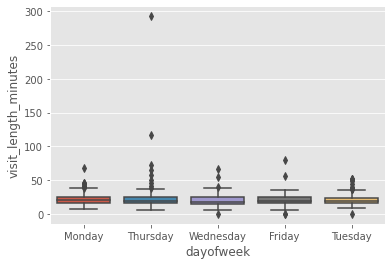

In [ ]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_final)

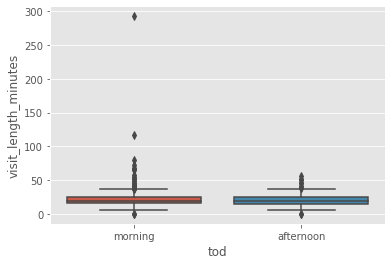

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

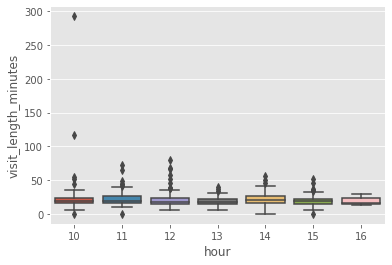

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

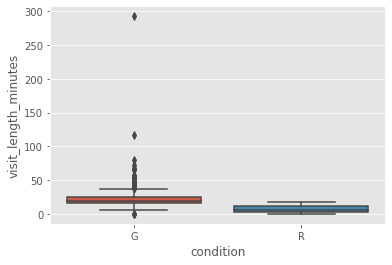

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

In [ ]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)]
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 17
newfrom                 17
newto                   17
visit_length            17
start_day               17
end_day                 17
sameday                 17
dayofweek               17
tod                     17
hour                    17
condition               17
visit_length_minutes    17
dtype: int64


In [ ]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G0132,2021-11-08 12:37:15,2021-11-08 12:54:54,0 days 00:17:39,8,8,equal,Monday,morning,12,G,17.6500
1,G0167,2021-11-11 13:34:30,2021-11-11 13:55:00,0 days 00:20:30,11,11,equal,Thursday,morning,13,G,20.5000
2,G0501,2021-10-11 10:50:32,2021-10-11 11:06:56,0 days 00:16:24,11,11,equal,Monday,morning,10,G,16.4000
3,G0502,2021-10-11 11:00:00,2021-10-11 11:22:25,0 days 00:22:25,11,11,equal,Monday,morning,11,G,22.4167
4,G0503,2021-10-11 11:28:09,2021-10-11 12:08:32,0 days 00:40:23,11,11,equal,Monday,morning,11,G,40.3833
...,...,...,...,...,...,...,...,...,...,...,...,...
676,G1219,2021-11-18 15:02:31,2021-11-18 15:21:23,0 days 00:18:52,18,18,equal,Thursday,afternoon,15,G,18.8667
677,G1220,2021-11-18 15:15:25,2021-11-18 15:34:04,0 days 00:18:39,18,18,equal,Thursday,afternoon,15,G,18.6500
678,R0620,2021-10-27 14:31:51,2021-10-27 14:31:53,0 days 00:00:02,27,27,equal,Wednesday,afternoon,14,R,0.0333
679,R0730,2021-11-03 13:31:30,2021-11-03 13:36:46,0 days 00:05:16,3,3,equal,Wednesday,morning,13,R,5.2667


In [ ]:
mean = df_outliers['visit_length_minutes'].mean()
print(mean)
print(df_nozero['visit_length_minutes'].mean())

20.819613670133727
20.819613670133727


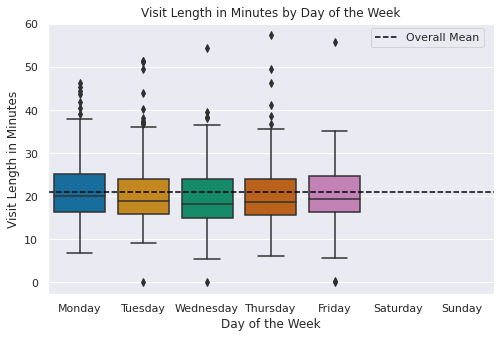

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated.png', bbox_inches='tight')

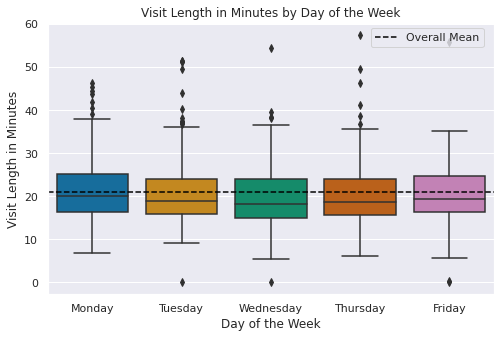

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated_noweekend.png', bbox_inches='tight')

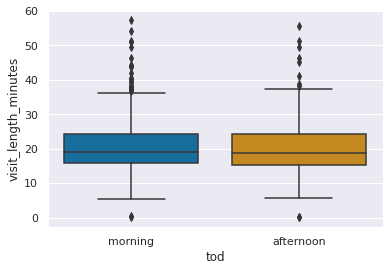

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

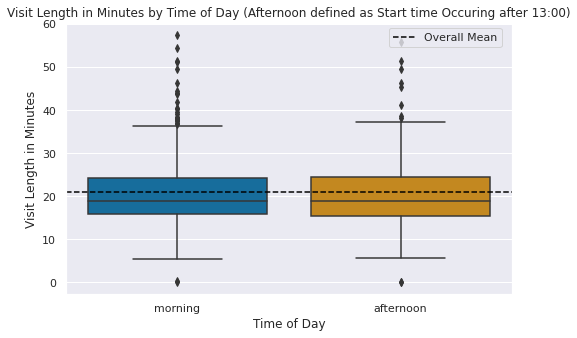

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Time of Day (Afternoon defined as Start time Occuring after 13:00)')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('timeofday_updated.png', bbox_inches='tight')

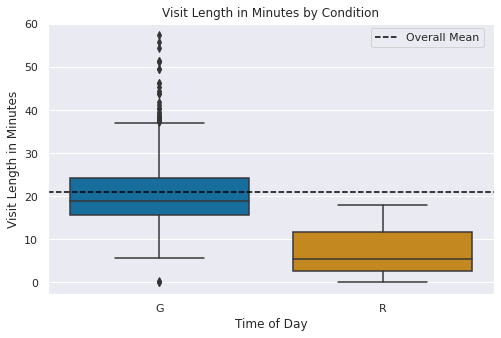

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Condition')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('condition_updated.png', bbox_inches='tight')

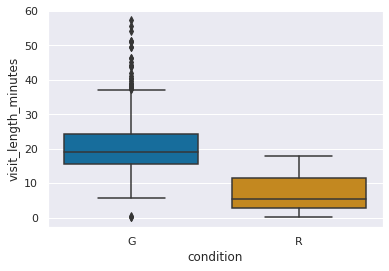

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

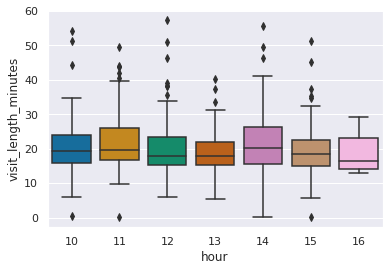

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

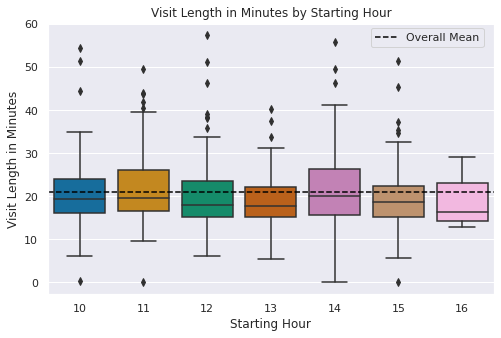

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Starting Hour')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('hour_updated.png', bbox_inches='tight')

In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df_outliers['visit_length_minutes'].describe()

count                                   673.0000
mean                                     20.8196
std                                       7.9442
min                                       0.0333
25%                                      15.6167
50%                                      18.8667
75%                                      24.1500
max                                      57.4000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].describe()

count                                   680.0000
mean                                     21.7256
std                                      14.2285
min                                       0.0333
25%                                      15.6583
50%                                      18.9167
75%                                      24.4625
max                                     292.6167
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].median()

18.916666666666668

In [ ]:
df_outliers['visit_length'].describe()

count                          673
mean     0 days 00:20:49.176820208
std      0 days 00:07:56.651767725
min                0 days 00:00:02
25%                0 days 00:15:37
50%                0 days 00:18:52
75%                0 days 00:24:09
max                0 days 00:57:24
Name: visit_length, dtype: object

In [ ]:
df_final['visit_length'].describe()

count                          680
mean     0 days 00:21:43.538235294
std      0 days 00:14:13.711742528
min                0 days 00:00:02
25%         0 days 00:15:39.500000
50%                0 days 00:18:55
75%         0 days 00:24:27.750000
max                0 days 04:52:37
Name: visit_length, dtype: object

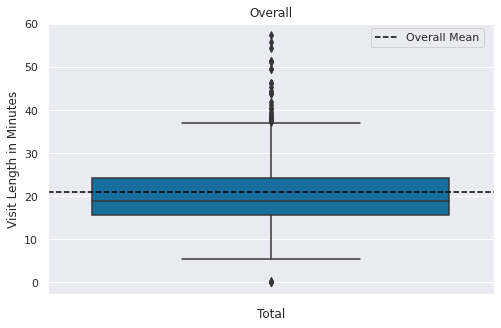

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)
svm.set_title('Overall')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('tested.png', bbox_inches='tight')

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
131
Eleven
134
Twelve
86
One
51
Two
146
Three
107
Four
18


In [ ]:
print('Monday Outlier')
mondayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Monday'].count()
print(mondayoutlier)

print('Tuesday Outlier')
tuesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Tuesday'].count()
print(tuesdayoutlier)

print('Wednesday Outlier')
wednesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Wednesday'].count()
print(wednesdayoutlier)

print('Thursday Outlier')
thursdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Thursday'].count()
print(thursdayoutlier)

print('Friday Outlier')
fridayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Friday'].count()
print(fridayoutlier)

print('Saturday Outlier')
saturdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Saturday'].count()
print(saturdayoutlier)

print('Sunday Outlier')
sundayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Sunday'].count()
print(sundayoutlier)

Monday Outlier
163
Tuesday Outlier
134
Wednesday Outlier
139
Thursday Outlier
132
Friday Outlier
105
Saturday Outlier
0
Sunday Outlier
0


In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length_minutes'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
dayoftheweekmean

dayofweek
Monday                                       21.4296
Tuesday                                      21.4139
Wednesday                                    19.8954
Thursday                                     20.6125
Friday                                       20.5981
Saturday                                         NaN
Sunday                                           NaN
Name: visit_length_minutes, dtype: float64

In [ ]:
print('G')
glaucomacount = df_outliers['condition'][df_outliers['condition']=='G'].count()
print(glaucomacount)

print('R')
rcount = df_outliers['condition'][df_outliers['condition']=='R'].count()
print(rcount)

G
670
R
3


In [ ]:
conditionmean = df_outliers.groupby('condition')['visit_length_minutes'].mean(numeric_only=False)
conditionmean

condition
G                                    20.8783
R                                     7.7167
Name: visit_length_minutes, dtype: float64

In [ ]:
print('morning')
morningcount = df_outliers['tod'][df_outliers['tod']=='morning'].count()
print(morningcount)

print('afternoon')
afternooncount = df_outliers['tod'][df_outliers['tod']=='afternoon'].count()
print(afternooncount)

morning
402
afternoon
271


In [ ]:
todmean = df_outliers.groupby('tod')['visit_length_minutes'].mean(numeric_only=False)
todmean

tod
afternoon                                    20.6333
morning                                      20.9452
Name: visit_length_minutes, dtype: float64

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
131
Eleven
134
Twelve
86
One
51
Two
146
Three
107
Four
18


In [ ]:
hourmean = df_outliers.groupby('hour')['visit_length_minutes'].mean(numeric_only=False)
hourmean

hour
10                                    20.6384
11                                    22.0122
12                                    20.7078
13                                    19.3301
14                                    21.5817
15                                    19.6933
16                                    18.5287
Name: visit_length_minutes, dtype: float64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count()

Patient                 17
newfrom                 17
newto                   17
visit_length            17
start_day               17
end_day                 17
sameday                 17
dayofweek               17
tod                     17
hour                    17
condition               17
visit_length_minutes    17
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] == 0).all(axis=1)].count()

Patient                 0
newfrom                 0
newto                   0
visit_length            0
start_day               0
end_day                 0
sameday                 0
dayofweek               0
tod                     0
hour                    0
condition               0
visit_length_minutes    0
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length']]).all(axis=1)].count()

Patient                 673
newfrom                 673
newto                   673
visit_length            673
start_day               673
end_day                 673
sameday                 673
dayofweek               673
tod                     673
hour                    673
condition               673
visit_length_minutes    673
dtype: int64

In [ ]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
678,R0620,2021-10-27 14:31:51,2021-10-27 14:31:53,0 days 00:00:02,27,27,equal,Wednesday,afternoon,14,R,0.0333
102,G0605,2021-10-19 15:29:33,2021-10-19 15:29:37,0 days 00:00:04,19,19,equal,Tuesday,afternoon,15,G,0.0667
259,G0766,2021-10-29 11:49:03,2021-10-29 11:49:09,0 days 00:00:06,29,29,equal,Friday,morning,11,G,0.1000
375,G0886,2021-11-05 10:45:33,2021-11-05 10:45:55,0 days 00:00:22,5,5,equal,Friday,morning,10,G,0.3667
679,R0730,2021-11-03 13:31:30,2021-11-03 13:36:46,0 days 00:05:16,3,3,equal,Wednesday,morning,13,R,5.2667


In [ ]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
678,R0620,2021-10-27 14:31:51,2021-10-27 14:31:53,0 days 00:00:02,27,27,equal,Wednesday,afternoon,14,R,0.0333
102,G0605,2021-10-19 15:29:33,2021-10-19 15:29:37,0 days 00:00:04,19,19,equal,Tuesday,afternoon,15,G,0.0667
259,G0766,2021-10-29 11:49:03,2021-10-29 11:49:09,0 days 00:00:06,29,29,equal,Friday,morning,11,G,0.1000
375,G0886,2021-11-05 10:45:33,2021-11-05 10:45:55,0 days 00:00:22,5,5,equal,Friday,morning,10,G,0.3667
679,R0730,2021-11-03 13:31:30,2021-11-03 13:36:46,0 days 00:05:16,3,3,equal,Wednesday,morning,13,R,5.2667


In [ ]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
238,G0745,2021-10-28 12:25:51,2021-10-28 13:23:15,0 days 00:57:24,28,28,equal,Thursday,morning,12,G,57.4000
489,G1017,2021-11-05 14:38:40,2021-11-05 15:34:22,0 days 00:55:42,5,5,equal,Friday,afternoon,14,G,55.7000
180,G0685,2021-10-27 10:35:03,2021-10-27 11:29:19,0 days 00:54:16,27,27,equal,Wednesday,morning,10,G,54.2667
455,G0979,2021-11-09 15:21:44,2021-11-09 16:13:05,0 days 00:51:21,9,9,equal,Tuesday,afternoon,15,G,51.3500
70,G0573,2021-10-19 10:36:16,2021-10-19 11:27:29,0 days 00:51:13,19,19,equal,Tuesday,morning,10,G,51.2167


In [ ]:
df_outliers.nlargest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
238,G0745,2021-10-28 12:25:51,2021-10-28 13:23:15,0 days 00:57:24,28,28,equal,Thursday,morning,12,G,57.4000
489,G1017,2021-11-05 14:38:40,2021-11-05 15:34:22,0 days 00:55:42,5,5,equal,Friday,afternoon,14,G,55.7000
180,G0685,2021-10-27 10:35:03,2021-10-27 11:29:19,0 days 00:54:16,27,27,equal,Wednesday,morning,10,G,54.2667
455,G0979,2021-11-09 15:21:44,2021-11-09 16:13:05,0 days 00:51:21,9,9,equal,Tuesday,afternoon,15,G,51.3500
70,G0573,2021-10-19 10:36:16,2021-10-19 11:27:29,0 days 00:51:13,19,19,equal,Tuesday,morning,10,G,51.2167


In [ ]:
df_final.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
304,G0813,2021-10-28 10:45:11,2021-10-28 15:37:48,0 days 04:52:37,28,28,equal,Thursday,morning,10,G,292.6167
11,G0510,2021-10-14 10:59:16,2021-10-14 12:56:23,0 days 01:57:07,14,14,equal,Thursday,morning,10,G,117.1167
383,G0895,2021-11-05 12:27:19,2021-11-05 13:47:52,0 days 01:20:33,5,5,equal,Friday,morning,12,G,80.5500
307,G0816,2021-10-28 11:59:18,2021-10-28 13:11:47,0 days 01:12:29,28,28,equal,Thursday,morning,11,G,72.4833
40,G0542,2021-10-11 12:17:06,2021-10-11 13:25:36,0 days 01:08:30,11,11,equal,Monday,morning,12,G,68.5000
188,G0693,2021-10-27 12:17:26,2021-10-27 13:23:31,0 days 01:06:05,27,27,equal,Wednesday,morning,12,G,66.0833
235,G0742,2021-10-28 11:42:17,2021-10-28 12:46:46,0 days 01:04:29,28,28,equal,Thursday,morning,11,G,64.4833
238,G0745,2021-10-28 12:25:51,2021-10-28 13:23:15,0 days 00:57:24,28,28,equal,Thursday,morning,12,G,57.4000
489,G1017,2021-11-05 14:38:40,2021-11-05 15:34:22,0 days 00:55:42,5,5,equal,Friday,afternoon,14,G,55.7000
180,G0685,2021-10-27 10:35:03,2021-10-27 11:29:19,0 days 00:54:16,27,27,equal,Wednesday,morning,10,G,54.2667


In [ ]:
df_outliers.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
238,G0745,2021-10-28 12:25:51,2021-10-28 13:23:15,0 days 00:57:24,28,28,equal,Thursday,morning,12,G,57.4000
489,G1017,2021-11-05 14:38:40,2021-11-05 15:34:22,0 days 00:55:42,5,5,equal,Friday,afternoon,14,G,55.7000
180,G0685,2021-10-27 10:35:03,2021-10-27 11:29:19,0 days 00:54:16,27,27,equal,Wednesday,morning,10,G,54.2667
455,G0979,2021-11-09 15:21:44,2021-11-09 16:13:05,0 days 00:51:21,9,9,equal,Tuesday,afternoon,15,G,51.3500
70,G0573,2021-10-19 10:36:16,2021-10-19 11:27:29,0 days 00:51:13,19,19,equal,Tuesday,morning,10,G,51.2167
429,G0948,2021-11-09 12:02:05,2021-11-09 12:53:04,0 days 00:50:59,9,9,equal,Tuesday,morning,12,G,50.9833
241,G0748,2021-10-28 14:21:39,2021-10-28 15:11:12,0 days 00:49:33,28,28,equal,Thursday,afternoon,14,G,49.5500
438,G0959,2021-11-09 11:04:15,2021-11-09 11:53:39,0 days 00:49:24,9,9,equal,Tuesday,morning,11,G,49.4000
57,G0559,2021-10-18 14:22:53,2021-10-18 15:09:08,0 days 00:46:15,18,18,equal,Monday,afternoon,14,G,46.2500
123,G0626,2021-10-21 12:25:03,2021-10-21 13:11:14,0 days 00:46:11,21,21,equal,Thursday,morning,12,G,46.1833


In [ ]:
df_outliers

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G0132,2021-11-08 12:37:15,2021-11-08 12:54:54,0 days 00:17:39,8,8,equal,Monday,morning,12,G,17.6500
1,G0167,2021-11-11 13:34:30,2021-11-11 13:55:00,0 days 00:20:30,11,11,equal,Thursday,morning,13,G,20.5000
2,G0501,2021-10-11 10:50:32,2021-10-11 11:06:56,0 days 00:16:24,11,11,equal,Monday,morning,10,G,16.4000
3,G0502,2021-10-11 11:00:00,2021-10-11 11:22:25,0 days 00:22:25,11,11,equal,Monday,morning,11,G,22.4167
4,G0503,2021-10-11 11:28:09,2021-10-11 12:08:32,0 days 00:40:23,11,11,equal,Monday,morning,11,G,40.3833
...,...,...,...,...,...,...,...,...,...,...,...,...
676,G1219,2021-11-18 15:02:31,2021-11-18 15:21:23,0 days 00:18:52,18,18,equal,Thursday,afternoon,15,G,18.8667
677,G1220,2021-11-18 15:15:25,2021-11-18 15:34:04,0 days 00:18:39,18,18,equal,Thursday,afternoon,15,G,18.6500
678,R0620,2021-10-27 14:31:51,2021-10-27 14:31:53,0 days 00:00:02,27,27,equal,Wednesday,afternoon,14,R,0.0333
679,R0730,2021-11-03 13:31:30,2021-11-03 13:36:46,0 days 00:05:16,3,3,equal,Wednesday,morning,13,R,5.2667


In [ ]:
df_outliers.loc[df_outliers['Patient'] == 'G1846']


,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes


## CSV Creation

This creates a csv of the dataframe so that it can potentially be used in subsequent analysis.

In [ ]:
df_outliers['clinic_location'] = 'HFA'
HFAdf = df_outliers[['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes', 'clinic_location']].copy()
HFAdf.to_csv('HFAdf_phase1.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
